
# Solving Blackjack with TD-Learning and Monte Carlo

In this tutorial, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

Checkout some gameplay without registration at: https://www.arkadium.com/games/blackjack/


### Blackjack Rules

1. **Objective**: The goal is to have a card sum greater than the dealer's without exceeding 21.
2. **States**: Each state is defined by:
   - The player's current sum (12-21).
   - The dealer's showing card (ace-10).
   - Whether the player has a usable ace.
3. **Rewards**: 
   - +1 for winning.
   - 0 for a draw.
   - -1 for losing.
4. **Actions**: The player can either "hit" (take another card) or "stick" (stop taking cards).
5. **Gameplay**: 
   - The player is dealt two cards initially and can choose to hit or stick.
   - The dealer then reveals one of their cards and follows a fixed strategy.
   - The game ends when the player sticks or exceeds 21, and the winner is determined based on the final sums.


**Approach**: To solve this environment by yourself, implement the TD(λ) algorithm. Change the values of λ to observe the varying behavior.


## Imports and Environment Setup




In [23]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import time

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True, render_mode='human')

## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [24]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# observation = (16, 9, False)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. In the Blackjack-v1 environment you can ignore it. 

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.

In [25]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




In [26]:
env.close()
# we close the environment since we want to train it without rendering, else it will be super slow

## Explanation of Monte Carlo, TD-Learning, and TD(λ)

**Monte Carlo Algorithm**:
Imagine you’re playing a game and you decide to learn from it only after it’s finished. That's Monte Carlo! It waits until the end of an episode, then takes the total reward and updates the values based on what happened throughout the whole game. It’s great because it uses the entire episode to make decisions, but sometimes it can be a bit wild with its estimates because it’s all-or-nothing.

**TD-Learning (Temporal Difference Learning)**:
Now, what if we don't want to wait until the end of the episode? Enter TD-Learning! It updates values step by step, using the immediate reward and the estimate of the next state. Think of it as learning on the fly. The classic one-step TD, or TD(0), updates after each step which helps in stabilizing the learning process. It’s less chaotic compared to Monte Carlo but can sometimes be biased because it’s just looking one step ahead.

**TD(λ)**:
Here’s where things get interesting. TD(λ) is like the best of both worlds. By adjusting the parameter λ (lambda), we can find the sweet spot between Monte Carlo and one-step TD. 
- Set λ to 1, and, you’ve got Monte Carlo learning from full episodes.
- Set λ to 0, and hey, it’s one-step TD all over again.
- With λ between 0 and 1, TD(λ) blends these approaches, balancing long-term and short-term learning.

### Why TD(λ)?
By implementing TD(λ), we get a lot more flexibility. We can make more frequent updates without waiting for an episode to end, and we can factor in multiple future steps to make our estimates better. Essentially, TD(λ) helps us balance between the extreme detailed look-ahead and the broader long-term returns. The theory in Grokking goes in depth into this and talks about the bias-variance trade-off, so, do check that out too.

### Time to Experiment
Experiment with different values of λ and see how your agent learns differently. Try λ at 0, 0.5, 0.9, 1, and note the changes.




## Building an agent

In [27]:
print(env.action_space)

Discrete(2)


In [28]:
class BlackjackTDAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
        lambda_: float = 0.9  # Adjustable lambda for TD(lambda)
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate, epsilon, and lambda.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
            lambda_: The decay rate for eligibility traces
        """
        # Initialize Q-values and eligibility traces
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.eligibility_traces = defaultdict(lambda: np.zeros(env.action_space.n))

        # Set hyperparameters
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.lambda_ = lambda_

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []
    '''
    def get_trajectory(self, get_action, env, max_steps):
        done, trajectory = False, []
        while not done:
            state = env.reset
            for t in range(max_steps):
                action = get_action(env,state)
                next_state , reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                experience = (state, action, reward, next_state, done)
                trajectory.append(experience)
                if done : 
                    break
                if t>=max_steps-1:
                    trajectory = []
                    break
                state = next_state
        return np.array(trajectory,np.object)
    '''
    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # Implement epsilon-greedy action selection here
        if np.random.random() < self.epsilon :
            return np.random.choice(env.action_space.n)
        else :
            return np.argmax(self.q_values[obs])
                 

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
        next_action: int
    ):
        """Updates the Q-value of an action using TD(lambda)."""
        # Calculate the future Q-value based on whether the state is terminal
        td_target = reward + self.discount_factor *self.q_values[next_obs][next_action] * (not terminated)
        
        # Calculate the temporal difference error
        temporal_difference = td_target - self.q_values[obs][action]

        # Update eligibility trace for the current state-action pair
        self.eligibility_traces[obs][action] += 1

        # Update all Q-values and eligibility traces
        for state, actions in self.q_values.items():
            for a in range(len(actions)):
                # Update Q-value based on temporal difference and eligibility trace
                self.q_values[state][a] += self.eligibility_traces[state][a]*temporal_difference*self.lr 
                
                # Decay the eligibility trace
                self.eligibility_traces[state][a] *= self.lambda_*self.discount_factor


        # Record the training error
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# Usage Example (to be filled in by students):
# Create the Blackjack environment
# env = gym.make('Blackjack-v0')
# Initialize the agent
# agent = BlackjackAgent(env, learning_rate=0.1, initial_epsilon=1.0, epsilon_decay=0.01, final_epsilon=0.1, discount_factor=0.95, lambda_=0.9)
# Implement the training loop (to be filled in by students)


In [29]:
# now make the environment for training without rendering
env = gym.make("Blackjack-v1", sab=True)

``n_episodes`` needs to be changed to a large value (remove the comment to train, after you have verified) to have proper amount of time to learn.
It is set to a small value initially just for you to check if your code is right, because afterwards, it will run for a long time to train.  

``learning_rate`` can also be tinkered with to control how fast the agent learns


In [30]:
# hyperparameters
learning_rate = 0.001

n_episodes = 1000_000
# n_episodes = 10

In [31]:
start_epsilon = 0.99
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.05

# change this value to observe different systems of TD learning
lambda_ = 0.8

In [32]:
agent = BlackjackTDAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    lambda_= lambda_
)

### Training Loop

In [33]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_action = agent.get_action(env, next_obs)
        # update the agent
        agent.update(obs, action, reward, terminated, next_obs, next_action)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [28:09<00:00, 591.87it/s] 


## Visualizing the training




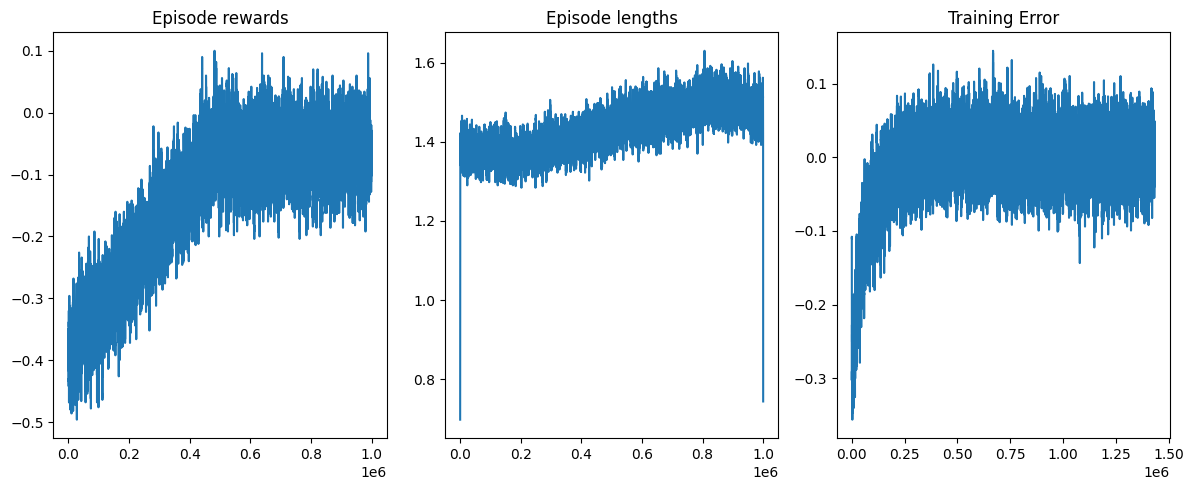

In [34]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

## Visualising the policy



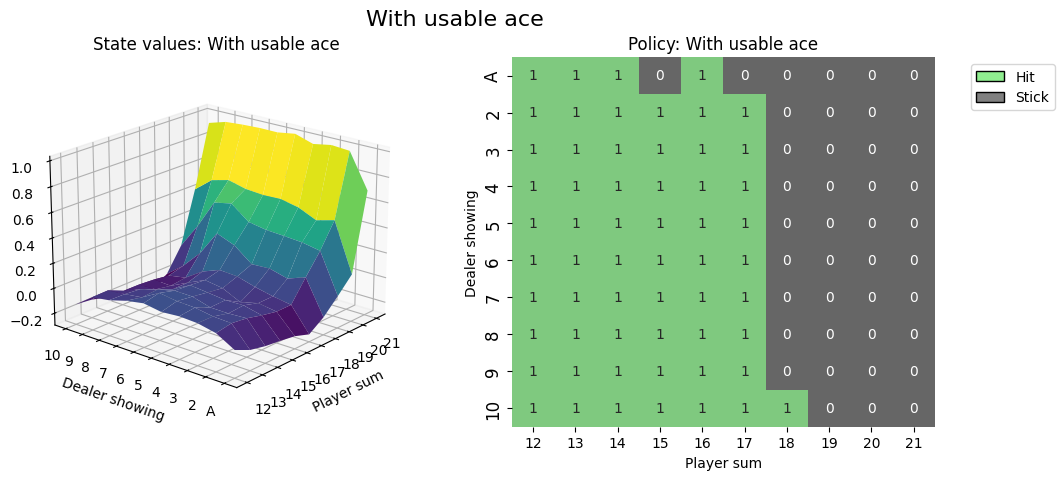

In [35]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

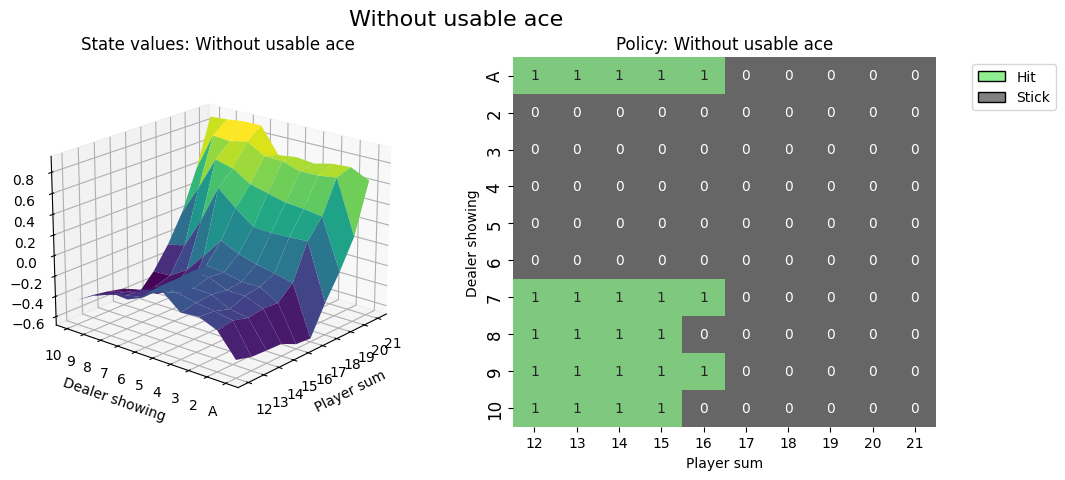

In [36]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

## Think your agent works?

Run the following function to see the fruits of your hardwork

In [37]:
env.close()

In [38]:
def watch_agent_play(agent, n_episodes=5, delay=1.0):
    """
    Function to watch the agent play the game for a given number of episodes with a delay between steps.
    
    Args:
        agent: The trained Blackjack agent
        env_name: The name of the environment
        n_episodes: Number of episodes to watch
        delay: Time delay (in seconds) between each step
    """
    env = gym.make("Blackjack-v1", sab=True, render_mode='human')

    for episode in range(n_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        
        print(f"Episode {episode + 1}\n{'-'*20}")
        
        while not done:
            env.render()
            time.sleep(delay)
            
            action = agent.get_action(env, obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            
            if action == 0:
                print("Agent decides to HIT")
            else:
                print("Agent decides to STICK")
            
            done = terminated or truncated
            obs = next_obs
            episode_reward += reward
            
            # Print the current situation
            print(f"Current Observation: {obs}")
            print(f"Current Reward: {episode_reward}\n")
            
            time.sleep(delay)
        
        if episode_reward > 0:
            result = "WIN"
        elif episode_reward < 0:
            result = "LOSE"
        else:
            result = "DRAW"
        
        print(f"Total Reward: {episode_reward} - Result: {result}\n")
        print(f"{'='*20}")
    
    env.close()


In [41]:
# run this function to watch your agent work its magic!
watch_agent_play(agent,10)

Episode 1
--------------------
Agent decides to STICK
Current Observation: (20, 5, 1)
Current Reward: 0.0

Agent decides to HIT
Current Observation: (20, 5, 1)
Current Reward: 1.0

Total Reward: 1.0 - Result: WIN

Episode 2
--------------------
Agent decides to STICK
Current Observation: (17, 10, 0)
Current Reward: 0.0

Agent decides to HIT
Current Observation: (17, 10, 0)
Current Reward: -1.0

Total Reward: -1.0 - Result: LOSE

Episode 3
--------------------
Agent decides to STICK
Current Observation: (22, 10, 0)
Current Reward: -1.0

Total Reward: -1.0 - Result: LOSE

Episode 4
--------------------
Agent decides to STICK
Current Observation: (18, 9, 0)
Current Reward: 0.0

Agent decides to HIT
Current Observation: (18, 9, 0)
Current Reward: 1.0

Total Reward: 1.0 - Result: WIN

Episode 5
--------------------
Agent decides to HIT
Current Observation: (17, 7, 0)
Current Reward: -1.0

Total Reward: -1.0 - Result: LOSE

Episode 6
--------------------
Agent decides to STICK
Current Observ

### That's it! Hope it was fun